In [32]:
%load_ext autoreload
%autoreload 2
import statistics
import matplotlib.pyplot as plt
import requests
import json
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import Database
from sklearn.preprocessing import MinMaxScaler
import Music
import Database
import Indicators

def standardizeDict(dict):
    dictMin = min(dict.values())
    dictMax = max(dict.values())
    for country in dict:
        dict[country] = (dict[country] - dictMin) / (dictMax - dictMin)
    return dict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:



# def getIndicatorDict(indicator):
#     indicatorDict = {}
#     cursor.execute(
#         '''
#         SELECT sampleID, country FROM sample;
#         '''
#     )
#     samples = cursor.fetchall()
#     for sampleID, country in samples:
#         if not country in indicatorDict:
#             indicatorDict[country] = []
#         cursor.execute(
#             f'''
#             SELECT {indicator} FROM indicator_set
#             WHERE sampleID = ?
#             ''', (sampleID,)
#         )
#         indicatorValue = cursor.fetchone()
#         if indicatorValue is not None and indicatorValue[0] is not None:
#             indicatorDict[country].append(indicatorValue[0])
#     noneKeys = []
#     for country in indicatorDict:
#         if indicatorDict[country] is not None and len(indicatorDict[country]):
#             indicatorDict[country] = statistics.median(indicatorDict[country])
#         else:
#             noneKeys.append(country)
#     for country in noneKeys:
#         del indicatorDict[country]
#     return indicatorDict




In [130]:

indicatorDF = Database.getIndicatorDF()
scaler = MinMaxScaler()

indicatorDF.iloc[:, 2:] = scaler.fit_transform(indicatorDF.iloc[:, 2:])
print(indicatorDF.to_string())


     sampleID                                               country  happiness_index  life_satisfaction  unemployment_rate  suicide_mortality_rate  educational_attainment  leisure_time  alcohol_consumption  health_expenditure  self_reported_depression  deaths_suicide_substance  perceived_health  employment_rate  social_support  life_expectancy  housing_affordability  disposable_income  homicides  median_lyric_sentiment
0           1                                               Finland         1.000000           1.000000           0.241757                0.206944                0.965517      0.510949             0.540476            0.456069                  0.475610                  0.726340          0.627949         0.819089        0.888853         0.886700               0.344827           0.542923   0.034965                0.530612
1           2                                               Denmark         0.973753           0.866667           0.160258                0.143056        

In [131]:
correlations = indicatorDF.iloc[:, 2:].corr()

feature_importance = correlations['median_lyric_sentiment'].abs().sort_values(ascending=False)
# print(indicatorDF.iloc[:,:2].columns)
# print(list(feature_importance.index))
indicatorDF = indicatorDF[list(indicatorDF.iloc[:,:2].columns) + list(feature_importance.index)]
print(indicatorDF)

     sampleID              country  median_lyric_sentiment  leisure_time  \
0           1              Finland                0.530612      0.510949   
1           2              Denmark                     NaN           NaN   
2           3              Iceland                     NaN           NaN   
3           4               Sweden                     NaN           NaN   
4           5               Israel                0.714286           NaN   
..        ...                  ...                     ...           ...   
285       429  St. Kitts and Nevis                     NaN           NaN   
286       430               Monaco                     NaN           NaN   
287       431     Marshall Islands                     NaN           NaN   
288       432                Palau                     NaN           NaN   
289       433           San Marino                     NaN           NaN   

     life_expectancy  deaths_suicide_substance  health_expenditure  \
0           0.886

     sampleID         country  median_lyric_sentiment  leisure_time  \
29         30       Singapore                1.000000           NaN   
9          10       Australia                0.928571      0.000000   
14         15          Canada                0.816327      0.299270   
19         20  United Kingdom                0.765306      0.448905   
4           5          Israel                0.714286           NaN   
54         55        Portugal                0.714286           NaN   
34         35          Poland                0.693878      0.248175   
59         60           China                0.663265           NaN   
134       135        Eswatini                0.653061           NaN   
22         23   United States                0.591837      0.233577   
49         50          Cyprus                0.571429           NaN   
44         45        Slovakia                0.561224           NaN   
24         25          Mexico                0.530612           NaN   
0     

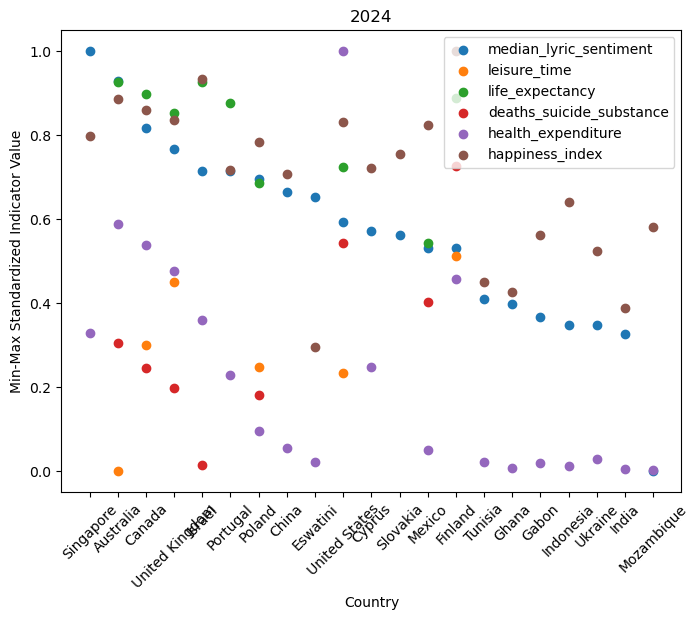

In [135]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plt.xticks(rotation=45)

axs.set_title("2024")
axs.set_ylabel("Min-Max Standardized Indicator Value")
axs.set_xlabel("Country")


indicatorDF = indicatorDF.iloc[:, :8]

indicatorDF = indicatorDF.dropna(subset='median_lyric_sentiment')
indicatorDF = indicatorDF.sort_values(by='median_lyric_sentiment', ascending=False)
print(indicatorDF)

for index, indicator in enumerate(indicatorDF.columns[2:]):

    # X_indicator = {k: X_indicator[k] for k in X_indicator if k in medianLyricSentiment}
    axs.scatter(indicatorDF['country'], indicatorDF[indicator], label=indicator)

plt.legend()
plt.show()